------
### Library setup and mounting g-drive 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# clone megatron model from official NVIDIA repository
!git clone https://github.com/NVIDIA/Megatron-LM
!git clone https://github.com/huggingface/transformers/

In [ ]:
%cd transformers
!mkdir megatron_lm_345m

In [ ]:
#!pip install git+https://github.com/huggingface/nlp
# !pip install --quiet transformers==2.11.0
!pip install --quiet transformers
!pip install --quiet nlp==0.2.0
!pip install --quiet datasets

In [ ]:
# !wget --content-disposition https://api.ngc.nvidia.com/v2/models/nvidia/megatron_lm_345m/versions/v0.0/zip -O megatron_lm_345m/checkpoint.zip
!wget --content-disposition https://api.ngc.nvidia.com/v2/models/nvidia/megatron_bert_345m/versions/v0.1_cased/zip -O megatron_lm_345m/checkpoint.zip
!python src/transformers/models/megatron_bert/convert_megatron_bert_checkpoint.py megatron_lm_345m/checkpoint.zip

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import transformers
import nlp
# from torch.utils.data import Dataset
from datasets import load_dataset, Dataset
import matplotlib.pyplot as plt
import logging
from sklearn.model_selection import train_test_split
logging.basicConfig(level=logging.INFO)

import json
from tqdm.notebook import tqdm

tqdm.pandas()

------
### Fetching our data


In [ ]:
# paths to semeval dataset
path_to_longform_textrank_data = "../dataset/semeval/"
path_to_train = f"{path_to_longform_textrank_data}train.csv"
path_to_test = f"{path_to_longform_textrank_data}test.csv"
path_to_validation = f"{path_to_longform_textrank_data}final_test_v1.csv"

# paths to fnc dataset
path_to_fnc_data = "../dataset/FNC/"
path_to_fnc_train = f"{path_to_fnc_data}train_v2.csv"
path_to_fnc_validation = f"{path_to_fnc_data}validation.csv"
path_to_fnc_test = f"{path_to_fnc_data}test_v2.csv"

# path to hyperpartisan pan data
path_to_pan_data = "../dataset/hyperpartisan_dataset/"
path_to_pan_train = f"{path_to_pan_data}train.csv"
path_to_pan_validation = f"{path_to_pan_data}validation.csv"
path_to_pan_test = f"{path_to_pan_data}test.csv"

In [ ]:
dataset_dict = {
  "stsb": load_dataset('glue', name='stsb'),
  "semeval": load_dataset('csv', data_files={
      'train': path_to_train,
      'validation': path_to_validation,
      'test': path_to_test,
  }),
  "fnc": load_dataset('csv', data_files={
      'train': path_to_fnc_train,
      'validation': path_to_fnc_validation,
      'test': path_to_fnc_test,
  }),
  "pan": load_dataset('csv', data_files={
      'train': path_to_pan_train,
      'validation': path_to_pan_validation,
      'test': path_to_pan_test,
  })
}

remove all the extra fields and phase data from rte and rename the fields.

In [ ]:
dataset_dict

We can show one example from each task.

In [ ]:
for task_name, dataset in dataset_dict.items():
    print(task_name)
    print(dataset_dict[task_name]["train"][0])
    print()

------
### Creating multitask training model

In [ ]:
class MultitaskModel(transformers.PreTrainedModel):
    def __init__(self, encoder, taskmodels_dict):
        """
        Setting MultitaskModel up as a PretrainedModel allows us
        to take better advantage of Trainer features
        """
        super().__init__(transformers.PretrainedConfig())

        self.encoder = encoder
        self.taskmodels_dict = nn.ModuleDict(taskmodels_dict)

    @classmethod
    def create(cls, model_name, model_type_dict, model_config_dict):
        """
        This creates a MultitaskModel using the model class and config objects
        from single-task models. 

        We do this by creating each single-task model, and having them share
        the same encoder transformer.
        """
        # print("PRINT: ", cls, type(cls))
        shared_encoder = None
        taskmodels_dict = {}
        for task_name, model_type in model_type_dict.items():
            model = model_type.from_pretrained(
                model_name, 
                config=model_config_dict[task_name],
            )
            # print(model)
            if shared_encoder is None:
                # print(cls.get_encoder_attr_name(model))
                shared_encoder = getattr(model, cls.get_encoder_attr_name(model))
                # print(getattr(model, cls.get_encoder_attr_name(model)))
            else:
                setattr(model, cls.get_encoder_attr_name(model), shared_encoder)
            taskmodels_dict[task_name] = model.to(device)

        # print(taskmodels_dict)

        return cls(encoder=shared_encoder, taskmodels_dict=taskmodels_dict)

    @classmethod
    def get_encoder_attr_name(cls, model):
        """
        The encoder transformer is named differently in each model "architecture".
        This method lets us get the name of the encoder attribute
        """
        model_class_name = model.__class__.__name__
        if model_class_name.startswith("Bert"):
            return "bert"
        elif model_class_name.startswith("Roberta"):
            return "roberta"
        elif model_class_name.startswith("Albert"):
            return "albert"
        elif model_class_name.startswith("Megatron"):
            return "bert"
        else:
            raise KeyError(f"Add support for new model {model_class_name}")

    def forward(self, task_name, **kwargs):
        output = self.taskmodels_dict[task_name](**kwargs)
        return output

As described above, the `MultitaskModel` class consists of only two components - the shared "encoder", a dictionary to the individual task models. Now, we can simply create the corresponding task models by supplying the invidual model classes and model configs. We will use Transformers' AutoModels to further automate the choice of model class given a model architecture (in our case, let's use `megatron`).

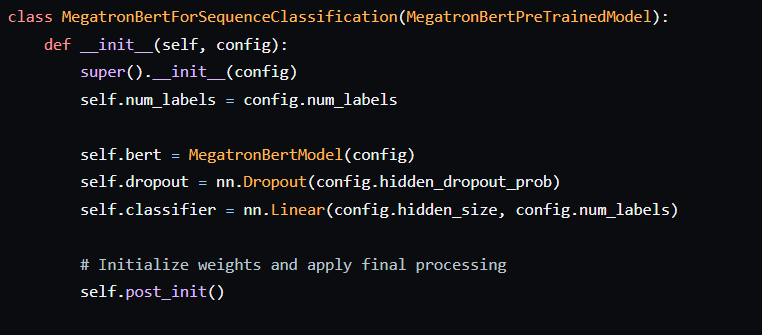

In [ ]:
model_name = "/content/transformers/megatron_lm_345m"
# model_name = "roberta-base"
multitask_model = MultitaskModel.create(
    model_name=model_name,
    model_type_dict={
        "stsb": transformers.AutoModelForSequenceClassification,
        "pan": transformers.AutoModelForSequenceClassification,
        "fnc": transformers.AutoModelForSequenceClassification,
        "semeval": transformers.AutoModelForSequenceClassification,
    },
    model_config_dict={
        "stsb": transformers.AutoConfig.from_pretrained(model_name, num_labels=1),
        "pan": transformers.AutoConfig.from_pretrained(model_name, num_labels=5),
        "fnc": transformers.AutoConfig.from_pretrained(model_name, num_labels=1),
        "semeval": transformers.AutoConfig.from_pretrained(model_name, num_labels=1),
    },
)

To confirm that all three task-models use the same encoder, we can check the data pointers of the respective encoders. In this case, we'll check that the word embeddings in each model all point to the same memory location.

In [ ]:
if model_name == "/content/transformers/megatron_lm_345m":
    print(multitask_model.encoder.embeddings.word_embeddings.weight.data_ptr())
    print(multitask_model.taskmodels_dict["stsb"].bert.embeddings.word_embeddings.weight.data_ptr())
    print(multitask_model.taskmodels_dict["semeval"].bert.embeddings.word_embeddings.weight.data_ptr())
else:
    print("Exercise for the reader: add a check for other model architectures =)")

## Processing our task data

We have created a dictionary of NLP datasets above, but we need to do a little more work to convert the respective task data into model inputs.

We'll start by first getting the tokenizer corresponding to our model.

In [ ]:
tokenizer_model_name = "nvidia/megatron-bert-uncased-345m"
# tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(tokenizer_model_name)
# don't judge the error

404 Client Error: Entry Not Found for url: https://huggingface.co/nvidia/megatron-bert-uncased-345m/resolve/main/config.json


------
### Preparation of dataset:

In [ ]:
max_length = 128

def convert_to_stsb_features(example_batch):
    inputs = list(zip(example_batch['sentence1'], example_batch['sentence2']))
    features = tokenizer.batch_encode_plus(
        inputs, max_length=max_length, padding="max_length", truncation=True
    )
    features["labels"] = example_batch["label"]
    return features

def convert_to_cola_features(example_batch):
    features = tokenizer.batch_encode_plus(
        example_batch["sentence"], max_length=max_length, pad_to_max_length=True
    )
    features["labels"] = example_batch["label"]
    return features

def convert_to_mrpc_features(example_batch):
    inputs = list(zip(example_batch['sentence1'], example_batch['sentence2']))
    features = tokenizer.batch_encode_plus(
        inputs, max_length=max_length, pad_to_max_length=True
    )
    features["labels"] = example_batch["label"]
    return features

def convert_to_semeval_features(example_batch):
    inputs = list(zip(example_batch['sentence1'], example_batch['sentence2']))
    features = tokenizer.batch_encode_plus(
        inputs, max_length=512, padding="max_length", truncation=True
    )
    features["labels"] = example_batch["label"]
    return features

def convert_to_rte_features(example_batch):
    inputs = list(zip(example_batch['sentence1'], example_batch['sentence2']))
    features = tokenizer.batch_encode_plus(
        inputs, max_length=max_length, pad_to_max_length=True
    )
    features["labels"] = example_batch["label"]
    return features

def convert_to_qnli_features(example_batch):
    inputs = list(zip(example_batch['question'], example_batch['sentence']))
    features = tokenizer.batch_encode_plus(
        inputs, max_length=max_length, pad_to_max_length=True
    )
    features["labels"] = example_batch["label"]
    return features

def convert_to_fnc_features(example_batch):
    inputs = list(zip(example_batch['Headline'], example_batch['articleBody']))
    features = tokenizer.batch_encode_plus(
        inputs, max_length=max_length, pad_to_max_length=True
    )
    # print(type(example_batch["Stance"]))

    features["labels"] = np.array(example_batch["Stance"]).astype(np.float)
    return features

def convert_to_fnid_features(example_batch):
    inputs = list(zip(example_batch['Headline'], example_batch['articleBody']))
    features = tokenizer.batch_encode_plus(
        inputs, max_length=max_length, pad_to_max_length=True
    )
    features["labels"] = example_batch["Stance"]
    return features

def convert_to_pan_features(example_batch):
    inputs = list(zip(example_batch['title'], example_batch['text']))
    features = tokenizer.batch_encode_plus(
        inputs, max_length=max_length, pad_to_max_length=True
    )
    features["labels"] = example_batch["bias"]
    return features

def convert_to_doc_nli_features(example_batch):
    inputs = list(zip(example_batch['premise'], example_batch['hypothesis']))
    features = tokenizer.batch_encode_plus(
        inputs, max_length=max_length, pad_to_max_length=True
    )
    features["labels"] = example_batch["label"]
    return features

convert_func_dict = {
    "stsb": convert_to_stsb_features,
    "semeval": convert_to_semeval_features,
}

Now that we have defined the above functions, we can use `dataset.map` method available in the NLP library to apply the functions over our entire datasets. The NLP library that handles the mapping efficiently and caches the features.

In [ ]:
# to ouput only errors, ignore the warnings
transformers.logging.set_verbosity_error()

In [ ]:
columns_dict = {
    "stsb": ['input_ids', 'attention_mask', 'labels'],
    "semeval": ['input_ids', 'attention_mask', 'labels'],
}

features_dict = {}
for task_name, dataset in dataset_dict.items():
    print(u"\u2192", task_name)
    features_dict[task_name] = {}
    for phase, phase_dataset in dataset.items():
        features_dict[task_name][phase] = phase_dataset.map(
            convert_func_dict[task_name],
            batched=True,
            load_from_cache_file=False,
        )
        features_dict[task_name][phase].set_format(
            type="torch", 
            columns=columns_dict[task_name],
        )
        print(task_name, phase, len(phase_dataset), len(features_dict[task_name][phase]))

## Preparing a multi-task data loader and Trainer

Setting up a multi-task data loader should be simple in principle - we simply need to sample from multiple single-task data loaders with some probability, and feed each batch to the multi-task model above. Of course, along with each batch, we also need to tell the model what task it is for, so `MultitaskModel` knows to use the right corresponding task-model.

However, because we want to use the built-in `Trainer` class in Transformers, this gets a little tricky, since the `Trainer` expects a single data loader, and expects a very specific format of per-batch data. This slice of code is somewhat of a hack around that constraint. (This can become a lot more streamlined with some tweaks to the Trainer code from the Hugging Face folks =))

We need to define a `MultitaskDataloader` that combines several data loaders into a single "data loader" - not so different from our multi-task model above! This `MultitaskDataloader` should do what we described: sample from different single-task data loaders, and yield a task batch and the corresponding task name (we're going to add the `task_name` to the batch data).

We will also need to override the `get_train_dataloader` method of the `Trainer` to play well with our `MultitaskDataloader`. We do this with a `MultitaskTrainer`.

In [ ]:
import dataclasses
from torch.utils.data.dataloader import DataLoader
# from transformers.training_args import is_tpu_available
# from transformers.trainer import get_tpu_sampler
from transformers.data.data_collator import DataCollator, InputDataClass, DefaultDataCollator
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.sampler import RandomSampler
from typing import List, Union, Dict


class NLPDataCollator(DefaultDataCollator):
    """
    Extending the existing DataCollator to work with NLP dataset batches
    """
    def collate_batch(self, features: List[Union[InputDataClass, Dict]]) -> Dict[str, torch.Tensor]:
        first = features[0]
        if isinstance(first, dict):
          # NLP data sets current works presents features as lists of dictionary
          # (one per example), so we  will adapt the collate_batch logic for that
          if "labels" in first and first["labels"] is not None:
              if first["labels"].dtype == torch.int64:
                  labels = torch.tensor([f["labels"] for f in features], dtype=torch.long)
              else:
                  labels = torch.tensor([f["labels"] for f in features], dtype=torch.float)
              batch = {"labels": labels}
          for k, v in first.items():
              if k != "labels" and v is not None and not isinstance(v, str):
                  batch[k] = torch.stack([f[k] for f in features])
          # push input_ids, attention_mask and labels to 'cuda'
          for k, v in batch.items():
              if v is not None and not isinstance(v, str):
                  batch[k] = v.to(device)
          return batch
        else:
          # otherwise, revert to using the default collate_batch
          return DefaultDataCollator().collate_batch(features)


class StrIgnoreDevice(str):
    """
    This is a hack. The Trainer is going call .to(device) on every input
    value, but we need to pass in an additional `task_name` string.
    This prevents it from throwing an error
    """
    def to(self, device):
        return self


class DataLoaderWithTaskname:
    """
    Wrapper around a DataLoader to also yield a task name
    """
    def __init__(self, task_name, data_loader):
        self.task_name = task_name
        self.data_loader = data_loader

        self.batch_size = data_loader.batch_size
        self.dataset = data_loader.dataset

    def __len__(self):
        return len(self.data_loader)
    
    def __iter__(self):
        for batch in self.data_loader:
            batch["task_name"] = StrIgnoreDevice(self.task_name)
            yield batch


class MultitaskDataloader:
    """
    Data loader that combines and samples from multiple single-task
    data loaders.
    """
    def __init__(self, dataloader_dict):
        self.dataloader_dict = dataloader_dict
        self.num_batches_dict = {
            task_name: len(dataloader) 
            for task_name, dataloader in self.dataloader_dict.items()
        }
        self.task_name_list = list(self.dataloader_dict)
        self.dataset = [None] * sum(
            len(dataloader.dataset) 
            for dataloader in self.dataloader_dict.values()
        )

    def __len__(self):
        return sum(self.num_batches_dict.values())

    def __iter__(self):
        """
        For each batch, sample a task, and yield a batch from the respective
        task Dataloader.

        We use size-proportional sampling, but you could easily modify this
        to sample from some-other distribution.
        """
        task_choice_list = []
        for i, task_name in enumerate(self.task_name_list):
            task_choice_list += [i] * self.num_batches_dict[task_name]
        task_choice_list = np.array(task_choice_list)
        np.random.shuffle(task_choice_list)
        dataloader_iter_dict = {
            task_name: iter(dataloader) 
            for task_name, dataloader in self.dataloader_dict.items()
        }
        for task_choice in task_choice_list:
            task_name = self.task_name_list[task_choice]
            yield next(dataloader_iter_dict[task_name])    

class MultitaskTrainer(transformers.Trainer):

    def get_single_train_dataloader(self, task_name, train_dataset):
        """
        Create a single-task data loader that also yields task names
        """
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")
        else:
            train_sampler = (
                RandomSampler(train_dataset)
                if self.args.local_rank == -1
                else DistributedSampler(train_dataset)
            )

        data_loader = DataLoaderWithTaskname(
            task_name=task_name,
            data_loader=DataLoader(
              train_dataset,
              batch_size=self.args.train_batch_size,
              sampler=train_sampler,
              collate_fn=self.data_collator.collate_batch,
            ),
        )
        return data_loader

    def get_train_dataloader(self):
        """
        Returns a MultitaskDataloader, which is not actually a Dataloader
        but an iterable that returns a generator that samples from each 
        task Dataloader
        """
        return MultitaskDataloader({
            task_name: self.get_single_train_dataloader(task_name, task_dataset)
            for task_name, task_dataset in self.train_dataset.items()
        })

## Time to train!

Okay, we have done all the hard work, now it is time for it to pay off. We can now simply create our `MultitaskTrainer`, and start training! 

In [ ]:
# title Default title text
train_dataset = {
    task_name: dataset["train"] 
    for task_name, dataset in features_dict.items()
}
trainer = MultitaskTrainer(
    model=multitask_model,
    args=transformers.TrainingArguments(
        output_dir="/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/train_models/model_6_megatron/models/multitask_model",
        overwrite_output_dir=True,
        learning_rate=1e-5,
        do_train=True,
        num_train_epochs=2,
        # Adjust batch size if this doesn't fit on the Colab GPU
        per_device_train_batch_size=1,  
        save_steps=10000,
    ),
    data_collator=NLPDataCollator(),
    train_dataset=train_dataset,
)
trainer.train()

In [ ]:
# wandb.finish()

-----
### Prediction

In [ ]:
from collections import defaultdict

preds = defaultdict(list)
batch_size = 1
# idx, attention_mask, input_ids, sentence1, sentence2, labels
task_name = 'semeval'
dataset = 'test'
val_len = len(features_dict[task_name][dataset])
# val_len = 20

for index in tqdm(range(0, val_len, batch_size), total=val_len):

    idx = features_dict[task_name][dataset][index]
    inputs = features_dict[task_name][dataset][index]

    overall, attention_mask, input_ids = inputs['labels'], inputs['attention_mask'].unsqueeze(0).to(device), inputs['input_ids'].unsqueeze(0).to(device)

    args = {'input_ids': input_ids, 'attention_mask': attention_mask}    
    # print(multitask_model(task_name, **args))
    overall_pred = multitask_model(task_name, **args)


    preds['idx'].append(features_dict[task_name][dataset]['idx'][index])
    preds['overall'].append(overall_pred['logits'].item())

In [ ]:
pred_overall = preds['overall']
rounded_overall = []

for pred in pred_overall:
    if pred >= 4:
        rounded_overall.append(4)
    elif pred <= 1:
        rounded_overall.append(1)
    else:
        rounded_overall.append(pred)

In [ ]:
nlp.load_metric('glue', name="stsb").compute(
    rounded_overall,
    features_dict[task_name][dataset]['labels'].tolist(),
)